In [3]:
import numpy as np
import os
# import xlrd
import openpyxl as xl
import pandas as pd
# from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as pl
%matplotlib inline
import seaborn as sns
# from plotly.offline import iplot, plot, init_notebook_mode
# from plotly import tools
# import plotly.plotly as py
# import plotly.graph_objs as go
# import plotly.io as pio
# import plotly
# plotly.tools.set_credentials_file(username='garyhan', api_key='jb6utiwqOF7F3bAuf1Td')
# init_notebook_mode(connected=True)
from mpl_toolkits.mplot3d import Axes3D

import math
from math import factorial
#import Image
from scipy import interpolate

In [12]:
def data_regularize(data, type="spherical", divs=10):
    limits = np.array([
        [min(data[:, 0]), max(data[:, 0])],
        [min(data[:, 1]), max(data[:, 1])],
        [min(data[:, 2]), max(data[:, 2])]])
        
    regularized = []

    if type == "cubic": # take mean from points in the cube
        
        X = np.linspace(*limits[0], num=divs)
        Y = np.linspace(*limits[1], num=divs)
        Z = np.linspace(*limits[2], num=divs)

        for i in range(divs-1):
            for j in range(divs-1):
                for k in range(divs-1):
                    points_in_sector = []
                    for point in data:
                        if (point[0] >= X[i] and point[0] < X[i+1] and
                                point[1] >= Y[j] and point[1] < Y[j+1] and
                                point[2] >= Z[k] and point[2] < Z[k+1]):
                            points_in_sector.append(point)
                    if len(points_in_sector) > 0:
                        regularized.append(np.mean(np.array(points_in_sector), axis=0))

    elif type == "spherical": #take mean from points in the sector
        divs_u = divs 
        divs_v = divs * 2

        center = np.array([
            0.5 * (limits[0, 0] + limits[0, 1]),
            0.5 * (limits[1, 0] + limits[1, 1]),
            0.5 * (limits[2, 0] + limits[2, 1])])
        d_c = data - center
    
        #spherical coordinates around center
        r_s = np.sqrt(d_c[:, 0]**2. + d_c[:, 1]**2. + d_c[:, 2]**2.)
        d_s = np.array([
            r_s,
            np.arccos(d_c[:, 2] / r_s),
            np.arctan2(d_c[:, 1], d_c[:, 0])]).T

        u = np.linspace(0, np.pi, num=divs_u)
        v = np.linspace(-np.pi, np.pi, num=divs_v)

        for i in range(divs_u - 1):
            for j in range(divs_v - 1):
                points_in_sector = []
                for k, point in enumerate(d_s):
                    if (point[1] >= u[i] and point[1] < u[i + 1] and
                            point[2] >= v[j] and point[2] < v[j + 1]):
                        points_in_sector.append(data[k])

                if len(points_in_sector) > 0:
                    regularized.append(np.mean(np.array(points_in_sector), axis=0))
# Other strategy of finding mean values in sectors
#                    p_sec = np.array(points_in_sector)
#                    R = np.mean(p_sec[:,0])
#                    U = (u[i] + u[i+1])*0.5
#                    V = (v[j] + v[j+1])*0.5
#                    x = R*math.sin(U)*math.cos(V)
#                    y = R*math.sin(U)*math.sin(V)
#                    z = R*math.cos(U)
#                    regularized.append(center + np.array([x,y,z]))
    return np.array(regularized)


# https://github.com/minillinim/ellipsoid
def ellipsoid_plot(center, radii, rotation, ax, plot_axes=False, cage_color='b', cage_alpha=0.2):
    """Plot an ellipsoid"""
        
    u = np.linspace(0.0, 2.0 * np.pi, 100)
    v = np.linspace(0.0, np.pi, 100)
    
    # cartesian coordinates that correspond to the spherical angles:
    x = radii[0] * np.outer(np.cos(u), np.sin(v))
    y = radii[1] * np.outer(np.sin(u), np.sin(v))
    z = radii[2] * np.outer(np.ones_like(u), np.cos(v))
    # rotate accordingly
    for i in range(len(x)):
        for j in range(len(x)):
            [x[i, j], y[i, j], z[i, j]] = np.dot([x[i, j], y[i, j], z[i, j]], rotation) + center

    if plot_axes:
        # make some purdy axes
        axes = np.array([[radii[0],0.0,0.0],
                         [0.0,radii[1],0.0],
                         [0.0,0.0,radii[2]]])
        # rotate accordingly
        for i in range(len(axes)):
            axes[i] = np.dot(axes[i], rotation)

        # plot axes
        for p in axes:
            X3 = np.linspace(-p[0], p[0], 100) + center[0]
            Y3 = np.linspace(-p[1], p[1], 100) + center[1]
            Z3 = np.linspace(-p[2], p[2], 100) + center[2]
            ax.plot(X3, Y3, Z3, color=cage_color)

    # plot ellipsoid
    ax.plot_wireframe(x, y, z, rstride=4, cstride=4, color=cage_color, alpha=cage_alpha)


# http://www.mathworks.com/matlabcentral/fileexchange/24693-ellipsoid-fit
# for arbitrary axes
def ellipsoid_fit(X):
    x = X[:, 0]
    y = X[:, 1]
    z = X[:, 2]
    D = np.array([x * x + y * y - 2 * z * z,
                 x * x + z * z - 2 * y * y,
                 2 * x * y,
                 2 * x * z,
                 2 * y * z,
                 2 * x,
                 2 * y,
                 2 * z,
                 1 - 0 * x])
    d2 = np.array(x * x + y * y + z * z).T # rhs for LLSQ
    u = np.linalg.solve(D.dot(D.T), D.dot(d2))
    a = np.array([u[0] + 1 * u[1] - 1])
    b = np.array([u[0] - 2 * u[1] - 1])
    c = np.array([u[1] - 2 * u[0] - 1])
    v = np.concatenate([a, b, c, u[2:]], axis=0).flatten()
    A = np.array([[v[0], v[3], v[4], v[6]],
                  [v[3], v[1], v[5], v[7]],
                  [v[4], v[5], v[2], v[8]],
                  [v[6], v[7], v[8], v[9]]])

    center = np.linalg.solve(- A[:3, :3], v[6:9])

    translation_matrix = np.eye(4)
    translation_matrix[3, :3] = center.T

    R = translation_matrix.dot(A).dot(translation_matrix.T)

    evals, evecs = np.linalg.eig(R[:3, :3] / -R[3, 3])
    evecs = evecs.T

    radii = np.sqrt(1. / np.abs(evals))
    radii *= np.sign(evals)

    return center, evecs, radii

In [ ]:
# the 10 parameters describing the ellipsoid / conic algebraically: 
# Ax^2 + By^2 + Cz^2 + 2Dxy + 2Exz + 2Fyz + 2Gx + 2Hy + 2Iz + J = 0

def in_ellipsoid(x):
    

center:  [ 1.70314251  0.2959531  -1.14646812]
radii:   [ 4.33756509 10.34226765 10.52217462]
evecs: 
 [[ 0.11201268  0.99279247  0.04261777]
 [ 0.98553028 -0.11647922  0.12313672]
 [-0.1272133  -0.02820823  0.99147419]]


Text(0.5, 0, 'Z')

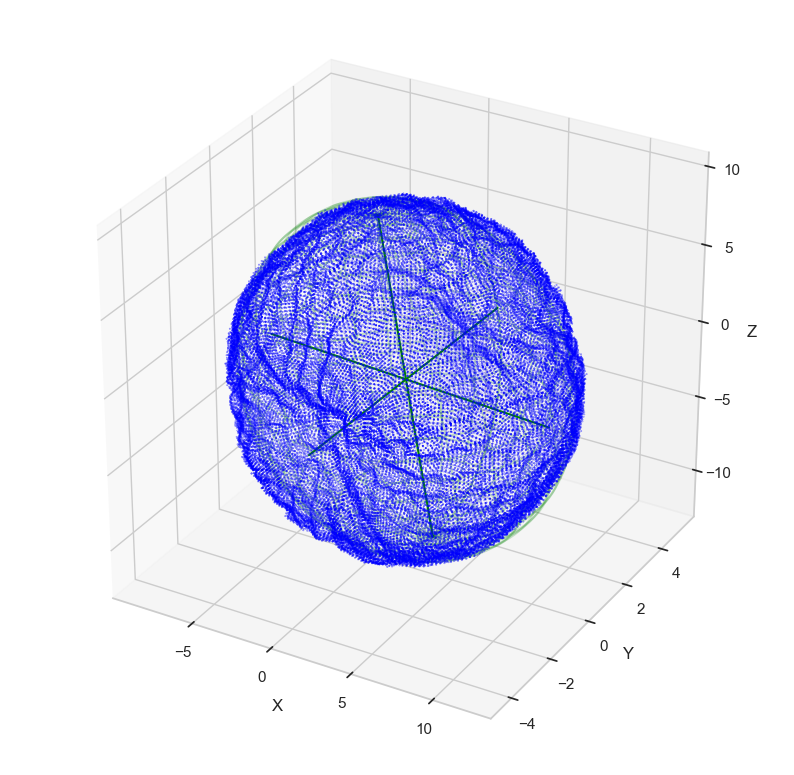

In [24]:
# center, evecs, radii = ellipsoid_fit()
# os.chdir('/Users/changnianhan/Downloads/simulation/')
os.chdir('C:/Users/garyh/Desktop')
plt = np.zeros((67004,3))
input_f = 'plt1'
with open(input_f, 'r') as in_f:
    for line in in_f:
        if 'vx' in line:
            for i in range(67004):
                line = next(in_f)
                plt[i][:] = line.strip().split()[1:4]

[c,e,r] = ellipsoid_fit(plt)
print('center: ', c)
print('radii:  ', r)
print('evecs: \n', e)

sns.set_style("whitegrid") # darkgrid, whitegrid, dark, white, ticks
sns.set_context("notebook") # paper, notebook, talk, poster

fig = pl.figure(figsize=(10, 10), dpi=100)
ax = fig.add_subplot(111, projection='3d')

ellipsoid_plot(c, r, e, ax=ax, plot_axes=True, cage_color='g')

ax.scatter(plt[:,0], plt[:,1], plt[:,2], s=0.1, c='blue')
ax.set_xlabel(r'X')
ax.set_ylabel(r'Y')
ax.set_zlabel(r'Z')

#hack  for equal axes
ax.set_aspect('equal')
# for direction in (-1, 1):
#     for point in np.diag(direction * np.max(data) * np.array([1, 1, 1])):
#         ax.plot([point[0]], [point[1]], [point[2]], 'w')

# ax.scatter(data_centered[:,0], data_centered[:,1], data_centered[:,2], marker='o', color='g')
# # ax.scatter(data_centered_regularized[:, 0], data_centered_regularized[:, 1],
# #            data_centered_regularized[:, 2], marker='o', color='b')
# ax.scatter(data_on_sphere[:, 0], data_on_sphere[:, 1],
#            data_on_sphere[:, 2], marker='o', color='r')

# ellipsoid_plot([0, 0, 0], radii, evecs, ax=ax, plot_axes=True, cage_color='g')
# ellipsoid_plot([0, 0, 0], [r, r, r], evecs, ax=ax, plot_axes=True, cage_color='orange')

#ax.plot([r],[0],[0],color='r',marker='o')
#ax.plot([radii[0]],[0],[0],color='b',marker='o')

In [ ]:
data = np.loadtxt("mag_out.txt")  # 3 columns data set
# data2 = data_regularize(data)

center, evecs, radii = ellipsoid_fit(data)

a, b, c = radii
r = (a * b * c) ** (1. / 3.)
D = np.array([[r/a, 0., 0.], [0., r/b, 0.], [0., 0., r/c]])
transformation = evecs.dot(D).dot(evecs.T)

print('')
print('center: ', center)
print('radii: ', radii)
print('evecs: ', evecs)
print('transformation:')
print(transformation)

################################################################

data = np.loadtxt("mag_out.txt")  # 3 columns data set
data2 = data_regularize(data, divs=8)

center, evecs, radii = ellipsoid_fit(data2)

data_centered = data - center.T
data_centered_regularized = data2 - center.T

a, b, c = radii
r = (a * b * c) ** (1. / 3.)
D = np.array([[r/a, 0., 0.], [0., r/b, 0.], [0., 0., r/c]])
#http://www.cs.brandeis.edu/~cs155/Lecture_07_6.pdf
#affine transformation from ellipsoid to sphere (translation excluded)
TR = evecs.dot(D).dot(evecs.T)
data_on_sphere = TR.dot(data_centered_regularized.T).T

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#hack  for equal axes
ax.set_aspect('equal')
for direction in (-1, 1):
    for point in np.diag(direction * np.max(data) * np.array([1, 1, 1])):
        ax.plot([point[0]], [point[1]], [point[2]], 'w')

ax.scatter(data_centered[:,0], data_centered[:,1], data_centered[:,2], marker='o', color='g')
# ax.scatter(data_centered_regularized[:, 0], data_centered_regularized[:, 1],
#            data_centered_regularized[:, 2], marker='o', color='b')
ax.scatter(data_on_sphere[:, 0], data_on_sphere[:, 1],
           data_on_sphere[:, 2], marker='o', color='r')

ellipsoid_plot([0, 0, 0], radii, evecs, ax=ax, plot_axes=True, cage_color='g')
ellipsoid_plot([0, 0, 0], [r, r, r], evecs, ax=ax, plot_axes=True, cage_color='orange')

#ax.plot([r],[0],[0],color='r',marker='o')
#ax.plot([radii[0]],[0],[0],color='b',marker='o')

plt.show()

## MATLAB version

In [12]:
def ellipsoid_fit_mat(point_data, mode=''):
    """ Fit an ellipsoid to a cloud of points using linear least squares
        Based on Yury Petrov MATLAB algorithm: "ellipsoid_fit.m"
    """

    X = point_data[:, 0]
    Y = point_data[:, 1]
    Z = point_data[:, 2]

    # AlGEBRAIC EQUATION FOR ELLIPSOID, from CARTESIAN DATA
    if mode == '':  # 9-DOF MODE
        D = np.array([X * X + Y * Y - 2 * Z * Z,
                      X * X + Z * Z - 2 * Y * Y,
                      2 * X * Y, 2 * X * Z, 2 * Y * Z,
                      2 * X, 2 * Y, 2 * Z,
                      1 + 0 * X]).T

    elif mode == 0:  # 6-DOF MODE (no rotation)
        D = np.array([X * X + Y * Y - 2 * Z * Z,
                      X * X + Z * Z - 2 * Y * Y,
                      2 * X, 2 * Y, 2 * Z,
                      1 + 0 * X]).T

    # THE RIGHT-HAND-SIDE OF THE LLSQ PROBLEM
    d2 = np.array([X * X + Y * Y + Z * Z]).T

    # SOLUTION TO NORMAL SYSTEM OF EQUATIONS
    u = np.linalg.solve(D.T.dot(D), D.T.dot(d2))
    # chi2 = (1 - (D.dot(u)) / d2) ^ 2

    # CONVERT BACK TO ALGEBRAIC FORM
    if mode == '':  # 9-DOF-MODE
        a = np.array([u[0] + 1 * u[1] - 1])
        b = np.array([u[0] - 2 * u[1] - 1])
        c = np.array([u[1] - 2 * u[0] - 1])
        v = np.concatenate([a, b, c, u[2:, :]], axis=0).flatten()

    elif mode == 0:  # 6-DOF-MODE
        a = u[0] + 1 * u[1] - 1
        b = u[0] - 2 * u[1] - 1
        c = u[1] - 2 * u[0] - 1
        zs = np.array([0, 0, 0])
        v = np.hstack((a, b, c, zs, u[2:, :].flatten()))

    else:
        pass

    # PUT IN ALGEBRAIC FORM FOR ELLIPSOID
    A = np.array([[v[0], v[3], v[4], v[6]],
                  [v[3], v[1], v[5], v[7]],
                  [v[4], v[5], v[2], v[8]],
                  [v[6], v[7], v[8], v[9]]])

    # FIND CENTRE OF ELLIPSOID
    centre = np.linalg.solve(-A[0:3, 0:3], v[6:9])

    # FORM THE CORRESPONDING TRANSLATION MATRIX
    T = np.eye(4)
    T[3, 0:3] = centre

    # TRANSLATE TO THE CENTRE, ROTATE
    R = T.dot(A).dot(T.T)

    # SOLVE THE EIGENPROBLEM
    evals, evecs = np.linalg.eig(R[0:3, 0:3] / -R[3, 3])

    # SORT EIGENVECTORS
    # i = np.argsort(evals)
    # evals = evals[i]
    # evecs = evecs[:, i]
    # evals = evals[::-1]
    # evecs = evecs[::-1]

    # CALCULATE SCALE FACTORS AND SIGNS
    radii = np.sqrt(1 / abs(evals))
    sgns = np.sign(evals)
    radii *= sgns

    return (centre, evecs, radii)

In [13]:
[c,e,r] = ellipsoid_fit_mat(plt)
print('center: ', c)
print('radii:  ', r)
print('evecs: \n', e)

center:  [-0.02131651 -0.00940477 -5.03356987]
radii:  [-0.14920345  0.14918819  6.42499082]
evecs:  [[-0.70710594  0.70710269  0.00264246]
 [ 0.70298364  0.70338007 -0.1052164 ]
 [ 0.07625745  0.07254153  0.99444584]]
